In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install transformers
!pip3 install pickle5
!pip install --upgrade --user pandas==1.3

     |████████████████████████████████| 3.5 MB 22.7 MB/s 
     |████████████████████████████████| 895 kB 57.2 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 6.8 MB 53.5 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 256 kB 27.2 MB/s 
     |████████████████████████████████| 10.8 MB 31.9 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import pickle5 as pickle
import torch


from pathlib import Path
from sklearn.manifold import TSNE
from transformers import AutoConfig, AutoTokenizer, AutoModel, TextClassificationPipeline, AutoModelForSequenceClassification
from tqdm import tqdm
from tqdm.autonotebook import trange
import torch.nn.functional as F

In [ ]:
PROJECT_DIR  = Path('/content/drive/MyDrive/few-shot-mr/')

BASE_MODEL = PROJECT_DIR.joinpath('MR_new/MR-RL-20-NORMAL')
MODELS = [PROJECT_DIR.joinpath(f'MR_new/{model}') for model in ['MR-RL-20-NORMAL', 'MR-RL-S20-0.9_la-0.6_SupCon_only_cls', 'MR-RL-S20-C25_0.4_m0.7_la-9_ga0.1_SoftTripleLoss_all']]

In [ ]:
with open(BASE_MODEL.joinpath("MR_all.pkl"), 'rb') as pickle_file:
  df = pickle.load(pickle_file)

df = df[~(df["sentence"].isin(["* \n", "\n", ""]))]
df.shape

(10662, 2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def batch_to_device(batch, target_device):
    """
    send a pytorch batch to a device (CPU/GPU)
    """
    for key in batch:
      batch[key] = batch[key].to(target_device)
    return batch

def prepare_predictions(examples, model, tokenizer, device, batch_size=4):
  predictions = []
  model = model.to(device)
  for start_index in trange(0, len(examples), batch_size, desc="Batches"):
    sentences_batch = examples[start_index:start_index+batch_size]
    features = tokenizer(sentences_batch, padding='max_length', max_length=512, truncation=True, return_tensors='pt')
    features = batch_to_device(features, device)
    outputs = model(**features)
    probas = F.softmax(outputs.logits, dim=1).detach()
    predictions.extend(probas.argmax(dim=1).cpu().numpy())
  return predictions


Prepare predictions

In [ ]:
examples = df['sentence'].tolist()
for model_path in MODELS:
  print(model_path)
  config = AutoConfig.from_pretrained(model_path)
  config.output_hidden_states = True

  tokenizer = AutoTokenizer.from_pretrained(model_path)
  model = AutoModelForSequenceClassification.from_pretrained(model_path, config=config)
  model_type = str(model_path).split("-")[-1].lower()
  pred = prepare_predictions(examples, model, tokenizer, device, batch_size=2)
  df[f'label_pred_{model_type}'] = pred

In [ ]:
df.head(5)

,sentence,label,label_pred_normal,label_pred_0.6_supcon_only_cls,label_pred_9_ga0.1_softtripleloss_all
9360,"smart , sassy interpretation of the oscar wild...",1,1,1,1
8730,its rawness and vitality give it considerable ...,1,1,1,1
2183,a compendium of solondz 's own worst instincts...,0,1,1,1
2231,"it 's fun , but a psychological mess , with au...",0,0,0,0
10108,"a fascinating examination of the joyous , turb...",1,1,1,1


In [ ]:
with open(BASE_MODEL.joinpath("MR_valid.pkl"), 'rb') as pickle_file:
  test = pickle.load(pickle_file)

with open(BASE_MODEL.joinpath("MR_train.pkl"), 'rb') as pickle_file:
  train = pickle.load(pickle_file)

df['dataset'] = "other"
df.loc[df['sentence'].isin(train['sentence']), 'dataset'] = "train"
df.loc[df['sentence'].isin(test['sentence']), 'dataset'] = "test"
df = df.rename(columns={
    'label_pred_0.6_supcon_only_cls': 'label_pred_supcon',
    'label_pred_9_ga0.1_softtripleloss_all': 'label_pred_softtripleloss' 
  })


In [ ]:
df.head(3)

,sentence,label,label_pred_normal,label_pred_supcon,label_pred_softtripleloss,dataset
9360,"smart , sassy interpretation of the oscar wild...",1,1,1,1,other
8730,its rawness and vitality give it considerable ...,1,1,1,1,other
2183,a compendium of solondz 's own worst instincts...,0,1,1,1,other


Calculate distance

In [ ]:
embeddings = np.load(PROJECT_DIR.joinpath('embeddings/20_MR_new/embeddings_normal_all.npy'))
mean_emb = np.mean(np.array(embeddings), axis=0)
df['distance'] = np.linalg.norm(np.array(embeddings) - mean_emb, axis=1)
df.to_csv(PROJECT_DIR.joinpath("df_mr_new.csv"), index=False)

In [ ]:
df = df[df['dataset'] != "train"]
df.shape

(10642, 10)

In [ ]:
df = df.sort_values("distance", ascending=False)
df.head(10)

,sentence,label,label_pred_normal,label_pred_supcon,label_pred_softtripleloss,dataset,distance,pred_proba_normal,pred_proba_0.6_supcon_only_cls,pred_proba_9_ga0.1_softtripleloss_all
43,'es en verdad una pena que mandoki estM-i real...,0,0,1,0,other,39.185510,0.106655,0.822552,0.319416
8503,y tu mamM-a tambiM-in es un buen filme gracias...,1,0,1,1,other,38.396687,0.206621,0.958708,0.965488
9140,"a cross between blow and boyz n the hood , thi...",0,0,0,0,other,37.647026,0.000182,0.006345,0.037863
1406,caso vocM-j sinta necessidade de sair da sala ...,0,1,1,1,other,37.141823,0.628507,0.885094,0.831478
8193,attal pushes too hard to make this a comedy or...,0,0,0,0,other,36.791798,0.000122,0.004425,0.037053
2087,mckay deflates his piece of puffery with a sou...,0,0,0,0,other,36.739628,0.018251,0.014724,0.033448
3536,nicolas cage is n't the first actor to lead a ...,0,0,0,0,other,36.674020,0.045825,0.125828,0.059785
8553,"it may be a prize winner , but teacher is a bo...",0,0,0,0,other,36.646500,0.000192,0.001315,0.033522
3026,atom egoyan has conjured up a multilayered wor...,1,0,1,1,other,36.492850,0.038213,0.975364,0.969642
857,"gives us a lot to chew on , but not all of it ...",1,0,0,0,other,36.392570,0.000148,0.001625,0.043029


In [ ]:
import math


list_group = sorted((list("0123456789") * math.ceil(df.shape[0]/10))[0:df.shape[0]])
len(list_group)

df['group'] = list_group
df.head()

,sentence,label,label_pred_normal,label_pred_supcon,label_pred_softtripleloss,dataset,distance,pred_proba_normal,pred_proba_0.6_supcon_only_cls,pred_proba_9_ga0.1_softtripleloss_all,group
43,'es en verdad una pena que mandoki estM-i real...,0,0,1,0,other,39.185510,0.106655,0.822552,0.319416,0
8503,y tu mamM-a tambiM-in es un buen filme gracias...,1,0,1,1,other,38.396687,0.206621,0.958708,0.965488,0
9140,"a cross between blow and boyz n the hood , thi...",0,0,0,0,other,37.647026,0.000182,0.006345,0.037863,0
1406,caso vocM-j sinta necessidade de sair da sala ...,0,1,1,1,other,37.141823,0.628507,0.885094,0.831478,0
8193,attal pushes too hard to make this a comedy or...,0,0,0,0,other,36.791798,0.000122,0.004425,0.037053,0


In [ ]:
df['correct_normal'] = (df['label'] == df['label_pred_normal']).astype(int)
df['correct_supcon'] = (df['label'] == df['label_pred_supcon']).astype(int)
df['correct_softtripleloss'] = (df['label'] == df['label_pred_softtripleloss']).astype(int)

In [ ]:
df.head()

,sentence,label,label_pred_normal,label_pred_supcon,label_pred_softtripleloss,dataset,distance,pred_proba_normal,pred_proba_0.6_supcon_only_cls,pred_proba_9_ga0.1_softtripleloss_all,group,correct_normal,correct_supcon,correct_softtripleloss
43,'es en verdad una pena que mandoki estM-i real...,0,0,1,0,other,39.185510,0.106655,0.822552,0.319416,0,1,0,1
8503,y tu mamM-a tambiM-in es un buen filme gracias...,1,0,1,1,other,38.396687,0.206621,0.958708,0.965488,0,0,1,1
9140,"a cross between blow and boyz n the hood , thi...",0,0,0,0,other,37.647026,0.000182,0.006345,0.037863,0,1,1,1
1406,caso vocM-j sinta necessidade de sair da sala ...,0,1,1,1,other,37.141823,0.628507,0.885094,0.831478,0,0,0,0
8193,attal pushes too hard to make this a comedy or...,0,0,0,0,other,36.791798,0.000122,0.004425,0.037053,0,1,1,1


In [ ]:
df_plot = df.groupby('group').agg(
    distance=("distance", "mean"),
    base=('correct_normal', 'mean'),
    supcon=('correct_supcon', 'mean'),
    softtripleloss=('correct_softtripleloss', 'mean'),
  ).reset_index(drop=True)

In [ ]:
df_plot = df_plot.melt(id_vars="distance").rename(columns={"value": "accuracy", "variable": "loss"})
df_plot.head(5)

,distance,loss,accuracy
0,33.119984,base,0.681690
1,30.662663,base,0.567136
2,27.492500,base,0.562970
3,23.651570,base,0.685150
4,22.066351,base,0.698308


In [ ]:
df_plot.loc[df_plot["loss"] == "supcon", "loss"] = "SupCon"
df_plot.loc[df_plot["loss"] == "softtripleloss", "loss"] = "SoftTriple"

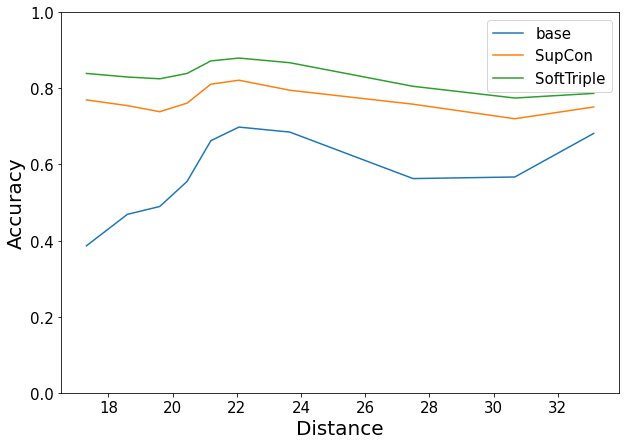

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.ylim(0, 1)
s = sns.lineplot(
    x='distance', 
    y='accuracy',
    hue='loss', 
    data=df_plot)
s.set_xlabel("Distance", fontsize=20)
s.set_ylabel("Accuracy", fontsize=20)
s.tick_params(labelsize=15)
plt.legend(prop={'size': 15})

plt.savefig(PROJECT_DIR.joinpath("embeddings/20_MR_new/distance_accuracy_nottrain.png"))
plt.show()

In [ ]:
df.tail(5)

,sentence,label,label_pred_supcon,label_pred_softtripleloss,dataset,label_pred_normal,distance,group,correct_normal,correct_supcon,correct_softtripleloss
4256,a summary of the plot does n't quite do justic...,0,0,0,other,0,12.548500,9,1,1,1
3405,disreputable doings and exquisite trappings ar...,0,1,0,other,0,12.547709,9,1,0,1
8083,bloody sunday has the grace to call for preven...,1,0,1,other,0,12.474362,9,0,0,1
1991,it offers little beyond the momentary joys of ...,0,0,0,other,0,12.341379,9,1,1,1
1566,a movie that hovers somewhere between an acute...,0,0,0,other,0,12.323551,9,1,1,1


### Model performance vs sentence length

In [ ]:
import pandas as pd

df = pd.read_csv(PROJECT_DIR.joinpath("df_mr.csv"))
df

,sentence,label,label_pred_supcon,label_pred_softtripleloss,dataset,label_pred_normal,distance
0,"smart , sassy interpretation of the oscar wild...",1,1,1,other,1,27.936060
1,its rawness and vitality give it considerable ...,1,1,1,other,1,27.577480
2,a compendium of solondz 's own worst instincts...,0,1,1,other,0,13.441463
3,"it 's fun , but a psychological mess , with au...",0,0,0,other,0,34.437748
4,"a fascinating examination of the joyous , turb...",1,1,1,other,1,16.037910
...,...,...,...,...,...,...,...
10657,"a sensitive , cultivated treatment of greene '...",1,1,1,other,1,24.499456
10658,. . . once the true impact of the day unfolds ...,1,1,1,other,1,18.166748
10659,bigelow handles the nuclear crisis sequences e...,0,0,0,other,0,15.997682
10660,poignant and delicately complex . \n,1,1,1,other,1,29.670180


In [ ]:
df['sentence_length'] =  [len(s.split()) for s in df['sentence']]

In [ ]:
df = df.sort_values("sentence_length", ascending=False)
df = df[df['dataset'] != "train"]
df.shape

(10642, 8)

In [ ]:
import math

list_group = sorted((list("0123456789") * math.ceil(df.shape[0]/10))[0:df.shape[0]])
print(len(list_group))

df['group'] = list_group
df.head()

10642


,sentence,label,label_pred_supcon,label_pred_softtripleloss,dataset,label_pred_normal,distance,sentence_length,group
8360,. . . a sour little movie at its core ; an exp...,1,0,0,other,0,19.001474,62,0
9773,"who are 'they ' ? well , they 're 'they ' . th...",0,0,0,other,0,28.750807,61,0
204,i have no problem with `` difficult `` movies ...,0,0,0,other,0,14.586335,60,0
5175,"it wo n't harm anyone , but neither can i thin...",0,0,0,other,0,22.045500,58,0
9144,the film is faithful to what one presumes are ...,1,0,0,other,0,15.789952,56,0


In [ ]:
df['correct_normal'] = (df['label'] == df['label_pred_normal']).astype(int)
df['correct_supcon'] = (df['label'] == df['label_pred_supcon']).astype(int)
df['correct_softtripleloss'] = (df['label'] == df['label_pred_softtripleloss']).astype(int)

In [ ]:
df_plot = df.groupby('group').agg(
    distance=("sentence_length", "mean"),
    base=('correct_normal', 'mean'),
    supcon=('correct_supcon', 'mean'),
    softtripleloss=('correct_softtripleloss', 'mean'),
  ).reset_index(drop=True)

df_plot = df_plot.melt(id_vars="distance").rename(columns={"value": "accuracy", "variable": "loss"})


df_plot.loc[df_plot["loss"] == "supcon", "loss"] = "SupCon"
df_plot.loc[df_plot["loss"] == "softtripleloss", "loss"] = "SoftTripleLoss"

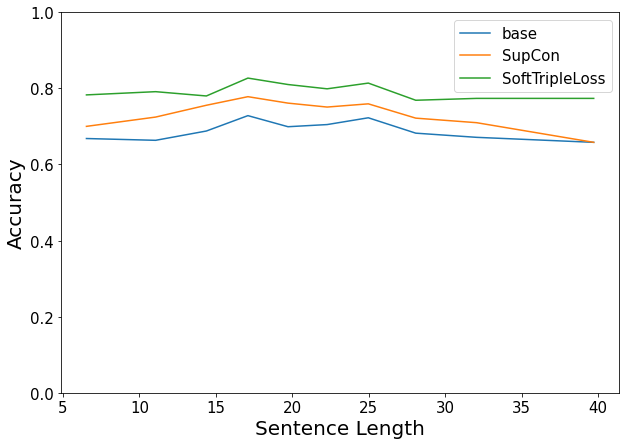

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))
plt.ylim(0, 1)
s = sns.lineplot(
    x='distance', 
    y='accuracy',
    hue='loss', 
    data=df_plot)
s.set_xlabel("Sentence Length", fontsize=20)
s.set_ylabel("Accuracy", fontsize=20)
s.tick_params(labelsize=15)
plt.legend(prop={'size': 15})

plt.savefig(PROJECT_DIR.joinpath("embeddings/20_MR/sentence_length_train.png"))
plt.show()